In [1]:
import sys
sys.path.insert(0, '/global/homes/z/zhzhuoqi/.local/cori/3.7-anaconda-2019.10/lib/python3.7/site-packages/TreeCorr-4.1-py3.7-linux-x86_64.egg')

In [2]:
import treecorr
treecorr.__version__

'4.1'

In [3]:
import GCRCatalogs
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import healpy as hp
import camb
import camb.correlations
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show, colorbar

In [4]:
def get_healpixel_footprint(ra, dec, nside, nest=False, count_threshold=None):
    pixels = hp.ang2pix(nside, ra, dec, nest=nest, lonlat=True)
    if count_threshold and count_threshold > 1:
        pixels, counts = np.unique(pixels, return_counts=True)
        return pixels[counts >= count_threshold]
    return np.unique(pixels)

In [5]:
def generate_uniform_random_ra_dec_healpixel(n, pix, nside, nest=False):

    ra, dec = hp.vec2ang(hp.boundaries(nside, pix, 1, nest=nest).T, lonlat=True)
    ra_dec_min_max = ra.min(), ra.max(), dec.min(), dec.max()

    ra = np.empty(n)
    dec = np.empty_like(ra)
    n_needed = n

    while n_needed > 0:
        ra_this, dec_this = generate_uniform_random_ra_dec_min_max(n_needed*2, *ra_dec_min_max)
        mask = np.where(hp.ang2pix(nside, ra_this, dec_this, nest=nest, lonlat=True) == pix)[0]
        count_this = mask.size
        if n_needed - count_this < 0:
            count_this = n_needed
            mask = mask[:n_needed]

        s = slice(-n_needed, -n_needed+count_this if -n_needed+count_this < 0 else None)
        ra[s] = ra_this[mask]
        dec[s] = dec_this[mask]
        n_needed -= count_this

    return ra, dec

def generate_uniform_random_ra_dec_min_max(n, ra_min, ra_max, dec_min, dec_max):

    ra = np.random.uniform(ra_min, ra_max, size=n)
    dec = np.random.uniform(np.sin(np.deg2rad(dec_min)), np.sin(np.deg2rad(dec_max)), size=n)
    dec = np.arcsin(dec, out=dec)
    dec = np.rad2deg(dec, out=dec)
    return ra, dec


In [6]:
def generate_uniform_random_ra_dec_footprint(n, footprint=None, nside=None, nest=False):

    if footprint is None or hp.nside2npix(nside) == len(footprint):
        return generate_uniform_random_ra_dec(n)

    n_per_pix_all = np.histogram(np.random.rand(n), np.linspace(0, 1, len(footprint)+1))[0]

    ra = np.empty(n)
    dec = np.empty_like(ra)
    count = 0

    for n_per_pix, pix in zip(n_per_pix_all, footprint):
        ra_this, dec_this = generate_uniform_random_ra_dec_healpixel(n_per_pix, pix, nside, nest)
        s = slice(count, count+n_per_pix)
        ra[s] = ra_this
        dec[s] = dec_this
        count += n_per_pix

    assert count == n

    return ra, dec


In [24]:
def theory_real_cross(lmax2, z_vals, n_vals, xvals):
    ''' Compute the correlation between galaxy shear and CMB lensing in real space '''
    ns = 0.963
    s8 = .8

    Omega_c = .22
    Omega_b = .0045
    h = 71./100.

    cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8 = s8, n_s = ns)#, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    cmbl1 = ccl.CMBLensingTracer(cosmo_ccl, 1100) # second number is source redshift
    lens1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(z_vals, n_vals))
    ll = np.arange(lmax2)

    num = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(z_vals, n_vals), bias = (z_vals,np.ones(len(z_vals))*1.3))
    #cls = ccl.angular_cl(cosmo_ccl, cmbl1, cmbl1, ll)
    cls = ccl.angular_cl(cosmo_ccl, lens1, cmbl1, ll) #k
    cls_num = ccl.angular_cl(cosmo_ccl,num,cmbl1,ll) #nk
    win = hp.pixwin(4096)[:lmax2]
    cls = cls*win**2
    pp3_2 = np.zeros((lmax2, 4))
    pp3_2[:, 0] = cls[:] * (ll * (ll + 1.)) / (2. * np.pi)
    cxvals = np.cos(xvals / (60.) / (180. / np.pi))
    vals = camb.correlations.cl2corr(pp3_2, cxvals)#from fourier space to real space
    #cls_num = cls_num*win**2
    pp3_2 = np.zeros((lmax2, 4))
    pp3_2[:, 0] = cls_num[:] * (ll * (ll + 1.)) / (2. * np.pi)
    cxvals = np.cos(xvals / (60.) / (180. / np.pi))
    vals2 = camb.correlations.cl2corr(pp3_2, cxvals)
    return xvals, vals[:, 0], vals2[:, 0]

In [25]:
filename = '/global/projecta/projectdirs/lsst/groups/CS/cosmoDC2/mass_sheets_behind_z3/cmb_maps/cmblensmap_total_gausshiz_masked.fits'

In [26]:
mapfile = hp.read_map(filename)
print(len(mapfile))

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
201326592


In [17]:
index = np.arange(201326592)
theta, phi = hp.pix2ang(nside=4096, ipix=index)

In [13]:
gc = GCRCatalogs.load_catalog('cosmoDC2')

In [14]:
data = gc.get_quantities(['ra', 'dec', 'redshift', 'mag_i_lsst'], filters=['mag_i_lsst<22'])

In [163]:
redshift_mask = (data['redshift']<0.3+0.1)*(data['redshift']>0.3)

[2227504 2227535 2227536 ... 2714479 2714559 2714575]


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([47.82348633, 47.96447081, 48.1054553 , 48.24643978, 48.38742426,
        48.52840875, 48.66939323, 48.81037772, 48.9513622 , 49.09234668,
        49.23333117, 49.37431565, 49.51530013, 49.65628462, 49.7972691 ,
        49.93825359, 50.07923807, 50.22022255, 50.36120704, 50.50219152,
        50.64317601, 50.78416049, 50.92514497, 51.06612946, 51.20711394,
        51.34809843, 51.48908291, 51.63006739, 51.77105188, 51.91203636,
        52.05302084, 52.19400533, 52.33498981, 52.4759743 , 52.61695878,
        52.75794326, 52.89892775, 53.03991223, 53.18089672, 53.3218812 ,
        53.46286568, 53.60385017, 53.74483465, 53.88581913, 54.02680362,
        54.1677881 , 54.30877259, 54.44975707, 54.59074155, 54.73172604,
        54.87271052, 

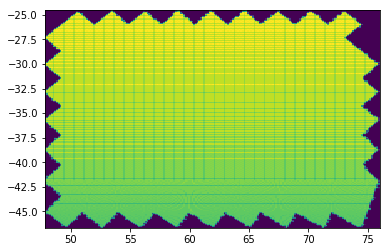

In [165]:
#cut out the CosmoDC2 region from KCMB
nside = 512
healpix_id = get_healpixel_footprint(data['ra'][redshift_mask], data['dec'][redshift_mask], nside) 
print(healpix_id)
npix = hp.nside2npix(nside)
m = np.zeros(npix)
m[healpix_id]=1
new = hp.ud_grade(m, 4096)
cmb_mask = new>0
ra_K = np.degrees(phi[cmb_mask])
dec_K = np.degrees(np.pi/2-theta[cmb_mask])
kcmb = mapfile[cmb_mask]
plt.hist2d(ra_K, dec_K, bins=200)

2160768


In [166]:
cat_N = treecorr.Catalog(ra=data['ra'][redshift_mask], dec=data['dec'][redshift_mask], ra_units='deg', dec_units='deg', npatch=40)
Npatch = cat_N.get_patch_centers()
#n = len(Npatch)
#print(Npatch)

In [167]:
cat_K = treecorr.Catalog(ra=ra_K, dec=dec_K, k=kcmb, ra_units='deg', dec_units='deg', patch_centers=Npatch)

In [168]:
#generate random ra and dec
n = len(data['ra'][redshift_mask])
nside = 512
healpix_id = get_healpixel_footprint(data['ra'][redshift_mask], data['dec'][redshift_mask], nside) #calculate NK with random galaxy distribution 
ra_random, dec_random = generate_uniform_random_ra_dec_footprint(n, footprint=healpix_id, nside=nside, nest=False)

In [169]:
cat_N_random = treecorr.Catalog(ra=ra_random, dec=dec_random, ra_units='deg', dec_units='deg', patch_centers=Npatch)

Text(0.5, 0.98, 'NK Correlation Random')

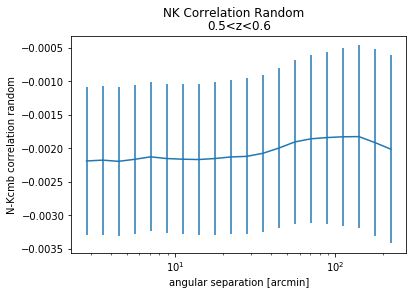

In [170]:
#calculate random correlation
nk_rand = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')
nk_rand.process(cat_N_random, cat_K)
xi_nk_random = nk_rand.xi
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.errorbar(np.degrees(R_nk)*60, nk_rand.xi, yerr=np.sqrt(nk_rand.varxi))
ax.set_title('0.5<z<0.6')
ax.set_xlabel('angular separation [arcmin]')
ax.set_ylabel('N-Kcmb correlation random')
fig.suptitle('NK Correlation Random')

In [171]:
nk = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')

In [172]:
nk.process(cat_N, cat_K)

In [174]:
nk.calculateXi(rk=nk_rand)
xi_nk = nk.xi
R_nk = np.exp(nk.logr)
varxi_nk = nk.varxi

Text(0.5, 0.98, 'NK Correlation Random')

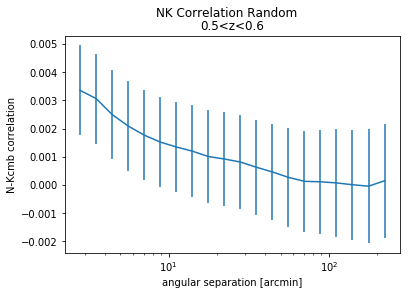

In [175]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.errorbar(np.degrees(R_nk)*60, xi_nk, yerr=np.sqrt(varxi_nk))
ax.set_title('0.5<z<0.6')
ax.set_xlabel('angular separation [arcmin]')
ax.set_ylabel('N-Kcmb correlation')
fig.suptitle('NK Correlation Random')
#fig.savefig('NK_corrected(1).png',dpi=200)

Text(0.5, 1.0, '0.5<z<0.6')

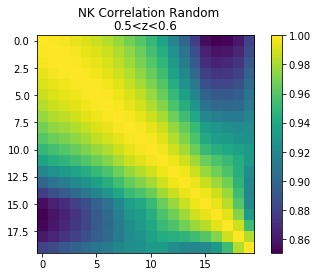

In [176]:
cov = nk.cov
norm_cov = cov.copy()
for i in range(len(cov)):
    for j in range(len(cov)):
        norm_cov[i][j]/=np.sqrt(cov[i][i]*cov[j][j])
plt.imshow(norm_cov)
plt.colorbar()
plt.suptitle("NK Correlation Random")
plt.title('0.5<z<0.6')
#plt.savefig("NK_cov_corrected(1).png", dpi=200)